# SC-VAR Usage

single cell ATAC-seq data

We assign noncoding SNPs to their target genes based on chromatin accessibility in disease-relevant tissues measured by single-cell ATAC sequence. 
Which can be used to find disease risk genes and pathways.

And by calculating the single-cell chromatin accessibility disease score 

Users can infer cell types involved in complex traits and diseases using single-cell epigenomes.

[ This branch does not rely on fine cell annotations and other Omics data. ]

In [2]:
!pip install sc-var

  Using cached sc_var-1.2.2-py3-none-any.whl (10 kB)


In [3]:
import scdrs
import scanpy as sc
from anndata import AnnData
from anndata import read_h5ad
from scipy import stats
import pandas as pd
import numpy as np
import sc_var
from sc_var import method as scv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import axes
import pylab
from matplotlib.pyplot import rc_context
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import episcanpy as epi
from cycler import cycler

warnings.filterwarnings("ignore")


## preprocessing data

GWAS SNP data format:

chr pos rsids pval

chr1    14773   rs878915777 0.13



==============

Peak data format:

gene chr start end

TTLL10  chr1    826700	827679

In [ ]:
#GWAS data
snp_list=scv.read_gwas('~/data/SCZ.txt')
                
#peak data ( Co-accessibility networks )
peak_list=scv.load_peak_data('~/data/atac_cis_coacess.txt')

Find the snp-peak overlap (Take times if data is large)

!! ATTENTION [choose the right reference genome]

check gencode webset for annotation version ( for now v43 for hg19 v44 for hg38)

In [ ]:
#overlp SNPs and peaks 
overlap_matrix = scv.snp_peak(peak_list,snp_list)
#find snp inside the gene body (load the annotatio file from the original magma pipline)
magma = scv.dmagma('~/data/magma0.genes.annot')
#get gene coordinates
corr = scv.gene_corr('~/data/gencode.v44.annotation.gff3.gz',peak_list)

## Get peak-snp-gene annotation

In [ ]:
#SCZ as example
anno=scv.annotate(overlap_matrix,corr,magma,'Schizophrenia.')

## Now you get the Peak-SNP-Gene annotation 

The annotation file saved to your working directory with filename like Schizophrenia.cmagma.genes.annot

Gene Analysis

In [ ]:
#Gene analysis
#choose the 1000 genome reference panel map your GWAS data
!magma\
    --bfile /g1000_eur/g1000_eur \                     
    --pval scz.txt use='rsids,pval' N=328748 \
    --gene-annot /Schizophrenia.cmagma.genes.annot \                                                   
    --out /output/cmagma


Gene set Analysis

In [ ]:
#Gene set analysis
#any gene set you are interested in by change the set-annot setting (c5 c8 or wiki etc.)
!magma \
    --gene-results Schizophrenia.cmagma.genes.raw\
    --set-annot /GSVA/c5.go.bp.v7.5.entrez.gmt \ 
    --out /cmagma_GSVA

## Cell Scoring

Identify disease association cell types using single cell ATAC-seq data

In [ ]:
#load scATAC-seq data
adata = sc.read_h5ad('~/atac.h5ad')

In [ ]:
#calculate  disease for each cells
#Take time to run 
df_score=scv.scads_atac(adata,overlap_matrix,'~/output/cmagma.genes.out','Schizophrenia')

You can  add each cells score into adata.obs for any downstream analysis

eg:

adata.obs['Schizophrenia'] = df_score['Schizophrenia']['norm_score']

In [ ]:
#statistical analysis 
df_group=scv.stat_analysis(
    adata=adata,
    df_full_score=df_score["Schizophrenia"],
    group_cols=["celltype"])

for key, df in df_group.items():
    #add key to filename
    df.to_csv(f"{key}_scv_group.celltype", sep="\t", index_col=0)

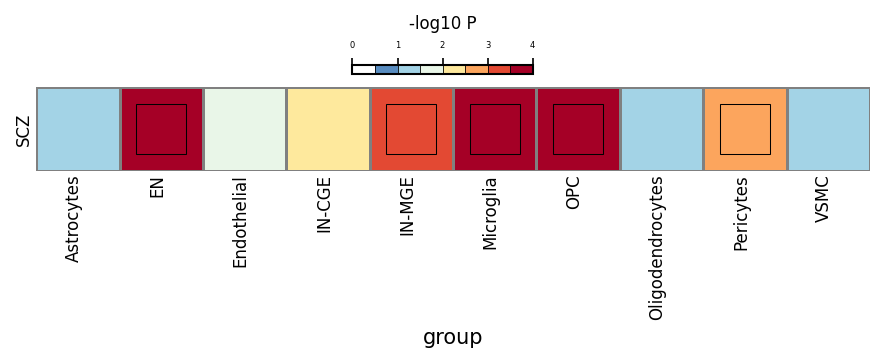

In [6]:
dict_GP_stats = {
    'SCZ': pd.read_csv(f"~/SCZ.scv_group.celltype", sep="\t", index_col=0)
}
scv.plot_group_stats(dict_GP_stats)
